# Import packages

In [1]:
import pandas as pd
import numpy as np
import sqlite3

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm

from datetime import datetime

import matplotlib.pyplot as plt

# Import dataset

In [2]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("../sncf_lostnfound.sqlite")
df = pd.read_sql_query("SELECT * from ObjetTrouve", con)

# Verify that result of SQL query is stored in the dataframe
print(df.head())

con.close()

   id          gare                        date  \
0   1  Lille Europe  2016-12-31 17:49:05.000000   
1   2  Lille Europe  2016-12-31 16:09:12.000000   
2   3  Lille Europe  2016-12-31 15:52:03.000000   
3   4  Lille Europe  2016-12-31 13:55:43.000000   
4   5  Lille Europe  2016-12-31 13:41:39.000000   

                                                type  \
0       Porte-monnaie / portefeuille, argent, titres   
1  Appareils électroniques, informatiques, appare...   
2           Pièces d'identités et papiers personnels   
3                Bagagerie: sacs, valises, cartables   
4                Bagagerie: sacs, valises, cartables   

                                     nature  
0                                  Chéquier  
1  Tablette tactile protégée (étui, housse)  
2                              Carte Vitale  
3                 Valise, sac sur roulettes  
4                                Sac à main  


# Prepare dataset - preprocessing, 

In [3]:
df.head()

,id,gare,date,type,nature
0,1,Lille Europe,2016-12-31 17:49:05.000000,"Porte-monnaie / portefeuille, argent, titres",Chéquier
1,2,Lille Europe,2016-12-31 16:09:12.000000,"Appareils électroniques, informatiques, appare...","Tablette tactile protégée (étui, housse)"
2,3,Lille Europe,2016-12-31 15:52:03.000000,Pièces d'identités et papiers personnels,Carte Vitale
3,4,Lille Europe,2016-12-31 13:55:43.000000,"Bagagerie: sacs, valises, cartables","Valise, sac sur roulettes"
4,5,Lille Europe,2016-12-31 13:41:39.000000,"Bagagerie: sacs, valises, cartables",Sac à main


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22200 entries, 0 to 22199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      22200 non-null  int64 
 1   gare    22200 non-null  object
 2   date    22200 non-null  object
 3   type    22200 non-null  object
 4   nature  22200 non-null  object
dtypes: int64(1), object(4)
memory usage: 867.3+ KB


In [5]:
df['datetime_obj'] = pd.to_datetime(df['date'])

In [6]:
df['year'] = pd.DatetimeIndex(df['datetime_obj']).year
df['month'] = pd.DatetimeIndex(df['datetime_obj']).month
df['month_name'] = pd.DatetimeIndex(df['datetime_obj']).month_name()
df['day'] = pd.DatetimeIndex(df['datetime_obj']).day
df['day_of_week'] = pd.DatetimeIndex(df['datetime_obj']).day_name()

df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)


df['year_week'] = df['datetime_obj'].dt.strftime('%Y-%U')
df['date_only'] = df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + df['day'].astype(str)

In [7]:
df_input_full = df.groupby(by = ['date_only'])['date_only'].count().reset_index(name='item_lost')

In [8]:
df_input = df_input_full['item_lost'].to_frame()

# Load into Model Arima

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values. Know more about parameters of ARIMA and its limitations, in this free video tutorial

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

In [9]:
model_arima = pm.auto_arima(df_input.item_lost, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14404.596, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18468.730, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=15769.632, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=17241.018, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=14405.881, Time=0.77 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=14405.877, Time=0.91 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=16606.025, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=15195.471, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=14406.296, Time=1.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=14399.443, Time=2.35 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=15007.694, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14937.780, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=14400.422, Time=2.39 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=14400.408, Time=2.64 sec
 ARIMA(0,0,0)(0,0,0

Pour savoir si la série est stationnaire on va utiliser le test de Dicker Fuller augmenté (adf). Son hypothèse nulle est que le processus n'est pas stationnaire. Si la p-value est inférieure à 0.05 on va donc rejeter cette hypothèse et considérer que le processus est stationaire.

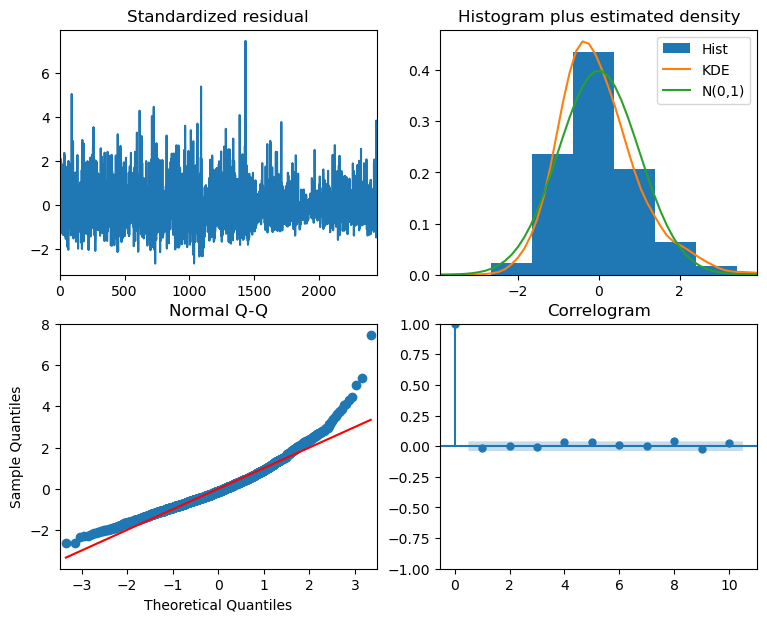

In [10]:
model_arima.plot_diagnostics(figsize=(9,7))
plt.show()

## Evaluate the seasonality

In [11]:

result = adfuller(df_input.item_lost.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.200689
p-value: 0.019945


Here the p-value is less than 0.05, so we can reject the null hypothesis and infer that the time series is indeed stationary.

### Désaisonnaliser une série temporelle

Use when p-value more than 0.05 , to make it stationary

[(0.0, 5.0), (-1.0, 25.0)]

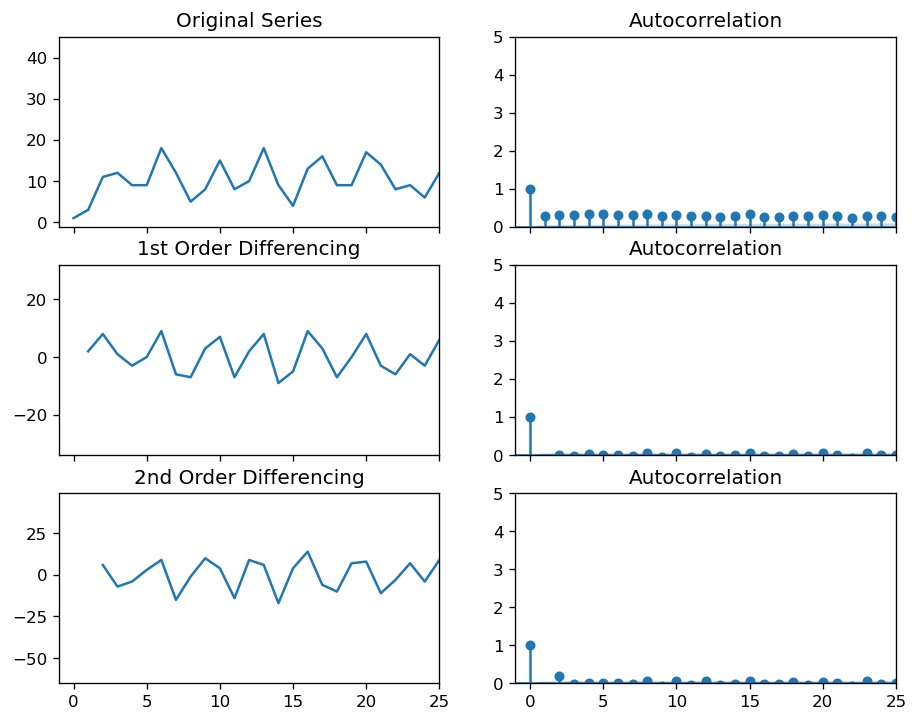

In [12]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_input.item_lost); axes[0, 0].set_title('Original Series')
plot_acf(df_input.item_lost, ax=axes[0, 1])
axes[0, 1].set(ylim=(0,5), xlim=(-1,25))

# 1st Differencing
axes[1, 0].plot(df_input.item_lost.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_input.item_lost.diff().dropna(), ax=axes[1, 1])
axes[1, 1].set(ylim=(0,5), xlim=(-1,25))

# 2nd Differencing
axes[2, 0].plot(df_input.item_lost.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_input.item_lost.diff().diff().dropna(), ax=axes[2, 1])
axes[2, 1].set(ylim=(0,5), xlim=(-1,25))


## Find the order of the AR term (p)

You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

But what is PACF?

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

c:\Users\Apprenant\anaconda3\envs\timeseries\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


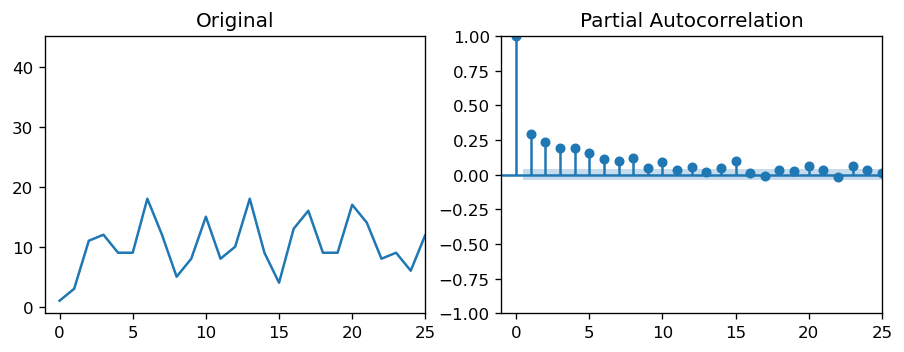

In [13]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
# axes[0].plot(df_input.item_lost.diff()); axes[0].set_title('1st Differencing')
# axes[1].set(ylim=(0,5))
# plot_pacf(df_input.item_lost.diff().dropna(), ax=axes[1])

axes[0].plot(df_input.item_lost); axes[0].set_title('Original')
axes[1].set(ylim=(0,5), xlim=(-1,25))
plot_pacf(df_input.item_lost.dropna(), ax=axes[1])

plt.show()

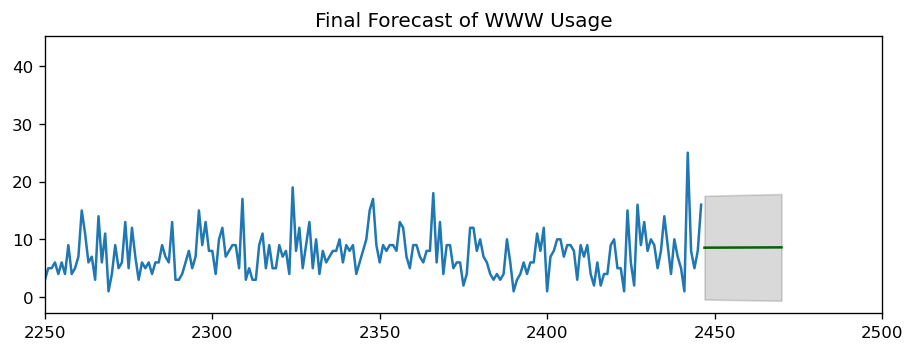

In [14]:
# Forecast
n_periods = 24
fc, confint = model_arima.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df_input.item_lost), len(df_input.item_lost)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_input.item_lost)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.xlim(2250,2500)
plt.show()

# Redo but using month
## Pre-processing

In [15]:
df_year_month_full = df.groupby(by = ['year_month'])['year_month'].count().reset_index(name='item_lost')
df_year_month = df_year_month_full['item_lost'].to_frame()

## Load model

In [16]:
model_arima_yr_mth = pm.auto_arima(df_year_month.item_lost, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_arima_yr_mth.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=902.371, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=914.151, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=908.862, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=904.176, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=912.162, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=904.371, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=904.371, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=903.234, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=909.005, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=906.205, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=900.815, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=902.337, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=906.907, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=902.814, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=902.8

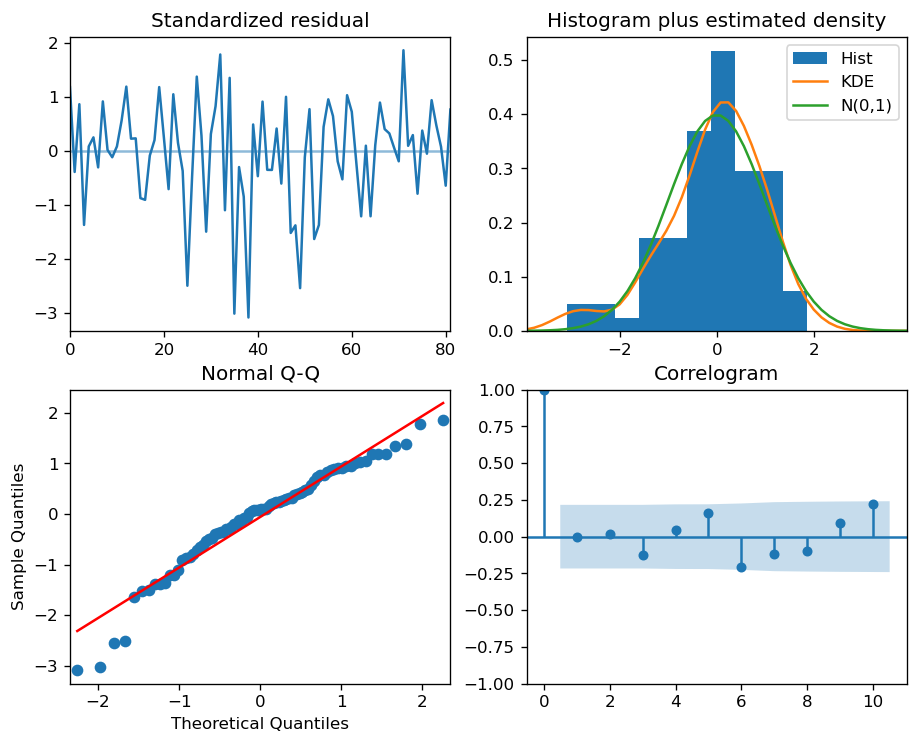

In [17]:
model_arima_yr_mth.plot_diagnostics(figsize=(9,7))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

## Evaluate the seasonality

In [18]:

result = adfuller(df_year_month.item_lost.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.571747
p-value: 0.497769


more than 0.05 --> not stationary

## Difference the series and see how the autocorrelation plot looks like.

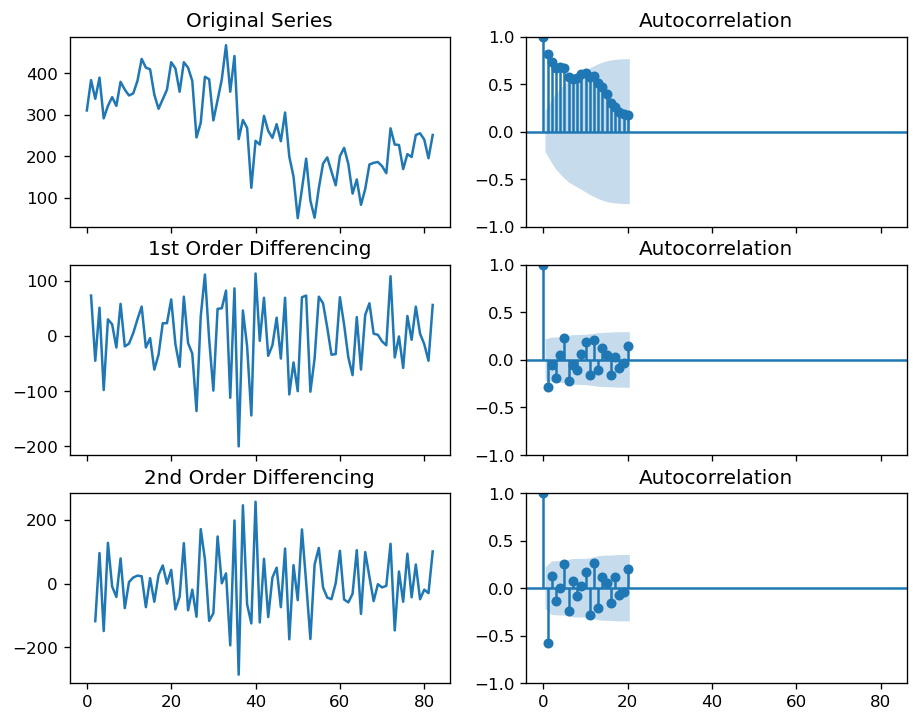

In [19]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_year_month.item_lost); axes[0, 0].set_title('Original Series')
plot_acf(df_year_month.item_lost, ax=axes[0, 1])
# axes[0, 1].set(ylim=(0,5), xlim=(-1,25))

# 1st Differencing
axes[1, 0].plot(df_year_month.item_lost.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_year_month.item_lost.diff().dropna(), ax=axes[1, 1])
# axes[1, 1].set(ylim=(0,5), xlim=(-1,25))

# 2nd Differencing
axes[2, 0].plot(df_year_month.item_lost.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_year_month.item_lost.diff().diff().dropna(), ax=axes[2, 1])
# axes[2, 1].set(ylim=(0,5), xlim=(-1,25))

plt.show()

In [20]:
df_year_month

,item_lost
0,310
1,383
2,338
3,389
4,291
...,...
78,251
79,255
80,240
81,195


c:\Users\Apprenant\anaconda3\envs\timeseries\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


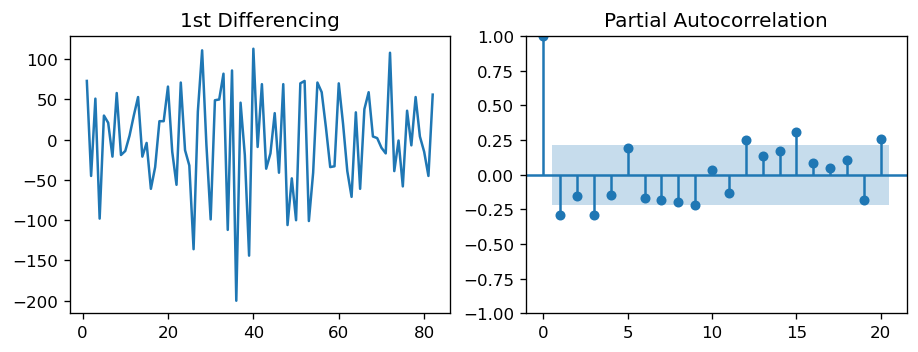

In [21]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df_year_month.item_lost.diff()); axes[0].set_title('1st Differencing'); 
axes[1].set(ylim=(0,5)); 
plot_pacf(df_year_month.item_lost.diff().dropna(), ax=axes[1])

# axes[0].plot(df_input.item_lost); axes[0].set_title('Original')
# axes[1].set(ylim=(0,5))
# plot_pacf(df_input.item_lost.dropna(), ax=axes[1])

plt.show()

p = 1

## Find the MA term

An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

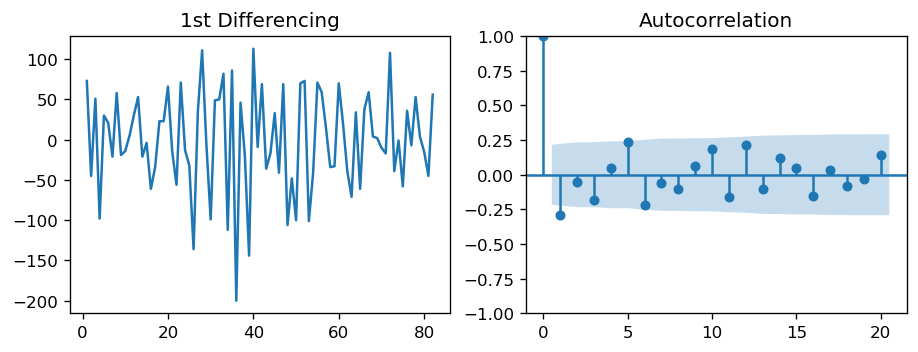

In [22]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df_year_month.item_lost.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_acf(df_year_month.item_lost.diff().dropna(), ax=axes[1])

plt.show()

q = 2

## Analysis

In [23]:
df_year_month

,item_lost
0,310
1,383
2,338
3,389
4,291
...,...
78,251
79,255
80,240
81,195


In [24]:
df_year_month[-9::]

,item_lost
74,227
75,169
76,205
77,198
78,251
79,255
80,240
81,195
82,251


In [25]:
df_year_month_test = df_year_month[-9::]

In [26]:
df_year_month_train = df_year_month[:-9]

In [27]:
# from statsmodels.tsa.arima_model import ARIMA
# import statsmodels.api as sm
# # 1,1,2 ARIMA Model
# mod = sm.tsa.ARIMA(df_year_month_train.item_lost, order=(1, 1, 1))
# mod_fit = mod.fit(df_year_month_train.item_lost)
# print(mod_fit.summary())

In [28]:
# Plot residual errors
# residuals = pd.DataFrame(mod_fit.resid)
# fig, ax = plt.subplots(1,2)
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.show()

In [29]:
model_arima_yr_mth_train = pm.auto_arima(df_year_month_train.item_lost, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_arima_yr_mth.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=809.558, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=819.698, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=815.341, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=811.367, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=817.720, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=811.556, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=811.556, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=810.502, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=815.441, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=813.545, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=808.429, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=809.557, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=813.389, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=810.428, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=810.4

In [30]:
output = model_arima_yr_mth_train.predict(10)

In [31]:
output

array([210.45479985, 204.16095836, 201.90322176, 201.09332297,
       200.80279481, 200.6985761 , 200.66119061, 200.64777962,
       200.64296881, 200.64124307])

In [32]:
df_year_month_test

,item_lost
74,227
75,169
76,205
77,198
78,251
79,255
80,240
81,195
82,251


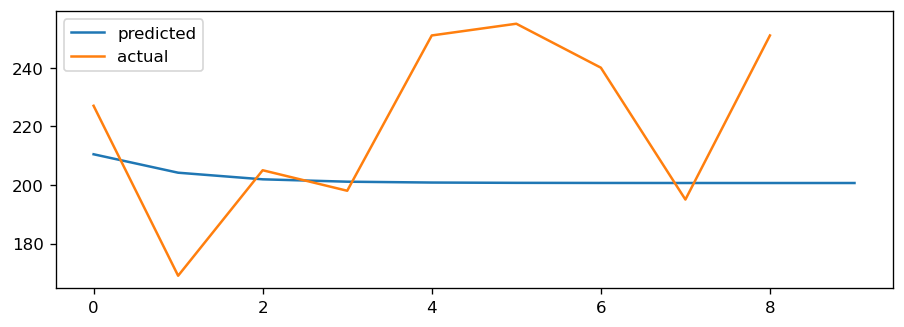

In [33]:
plt.plot(output, label='predicted')
plt.plot(df_year_month_test.reset_index(drop=True), label='actual')
plt.legend()


In [34]:
output

array([210.45479985, 204.16095836, 201.90322176, 201.09332297,
       200.80279481, 200.6985761 , 200.66119061, 200.64777962,
       200.64296881, 200.64124307])

## Build ARIMA Forecast Model

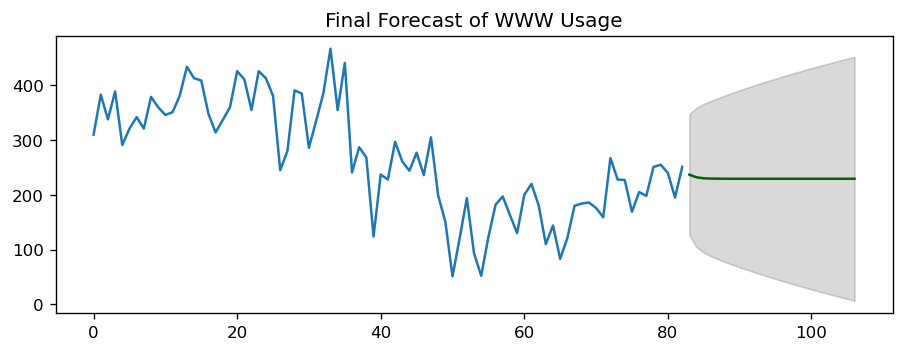

In [35]:
# Forecast
n_periods = 24
fc, confint = model_arima_yr_mth.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df_year_month.item_lost), len(df_year_month.item_lost)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_year_month.item_lost)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

In [36]:
model_arima_yr_mth.__dict__

{'order': (1, 1, 1),
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'method': 'lbfgs',
 'maxiter': 50,
 'suppress_warnings': True,
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'trend': None,
 'with_intercept': False,
 'sarimax_kwargs': {},
 'arima_res_': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x27e14f28e50>,
 'fit_with_exog_': False,
 'nobs_': 83,
 'pkg_version_': '1.8.5',
 'oob_': nan,
 'oob_preds_': None}

Ressources
time serie analysis: https://www.machinelearningplus.com/time-series/time-series-analysis-python/
ARIMA : https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/


# SARIMA

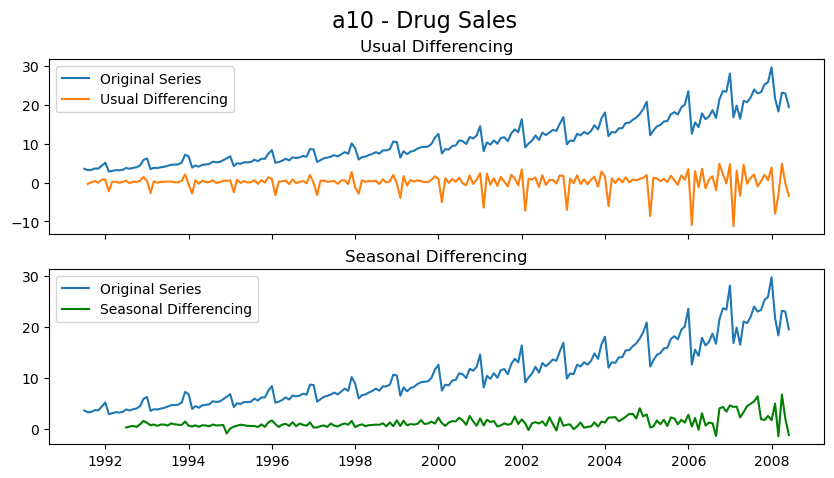

In [37]:
# Import
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [38]:
data

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


In [39]:
df_date_month = df_year_month_full

In [40]:
df_date_month

,year_month,item_lost
0,2016-1,310
1,2016-10,383
2,2016-11,338
3,2016-12,389
4,2016-2,291
...,...,...
78,2022-5,251
79,2022-6,255
80,2022-7,240
81,2022-8,195


In [41]:

df_date_month['year_month'] = pd.to_datetime(df_date_month['year_month'])

In [42]:
df_date_month

,year_month,item_lost
0,2016-01-01,310
1,2016-10-01,383
2,2016-11-01,338
3,2016-12-01,389
4,2016-02-01,291
...,...,...
78,2022-05-01,251
79,2022-06-01,255
80,2022-07-01,240
81,2022-08-01,195


In [43]:
df_date_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year_month  83 non-null     datetime64[ns]
 1   item_lost   83 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.4 KB


In [44]:
df_date_month.set_index('year_month', inplace=True,drop=True)

In [45]:
df_date_month = df_date_month.sort_index()

In [46]:
df_date_month[:]

,item_lost
year_month,
2016-01-01,310
2016-02-01,291
2016-03-01,321
2016-04-01,342
2016-05-01,321
...,...
2022-08-01,195
2022-09-01,251
2022-10-01,267


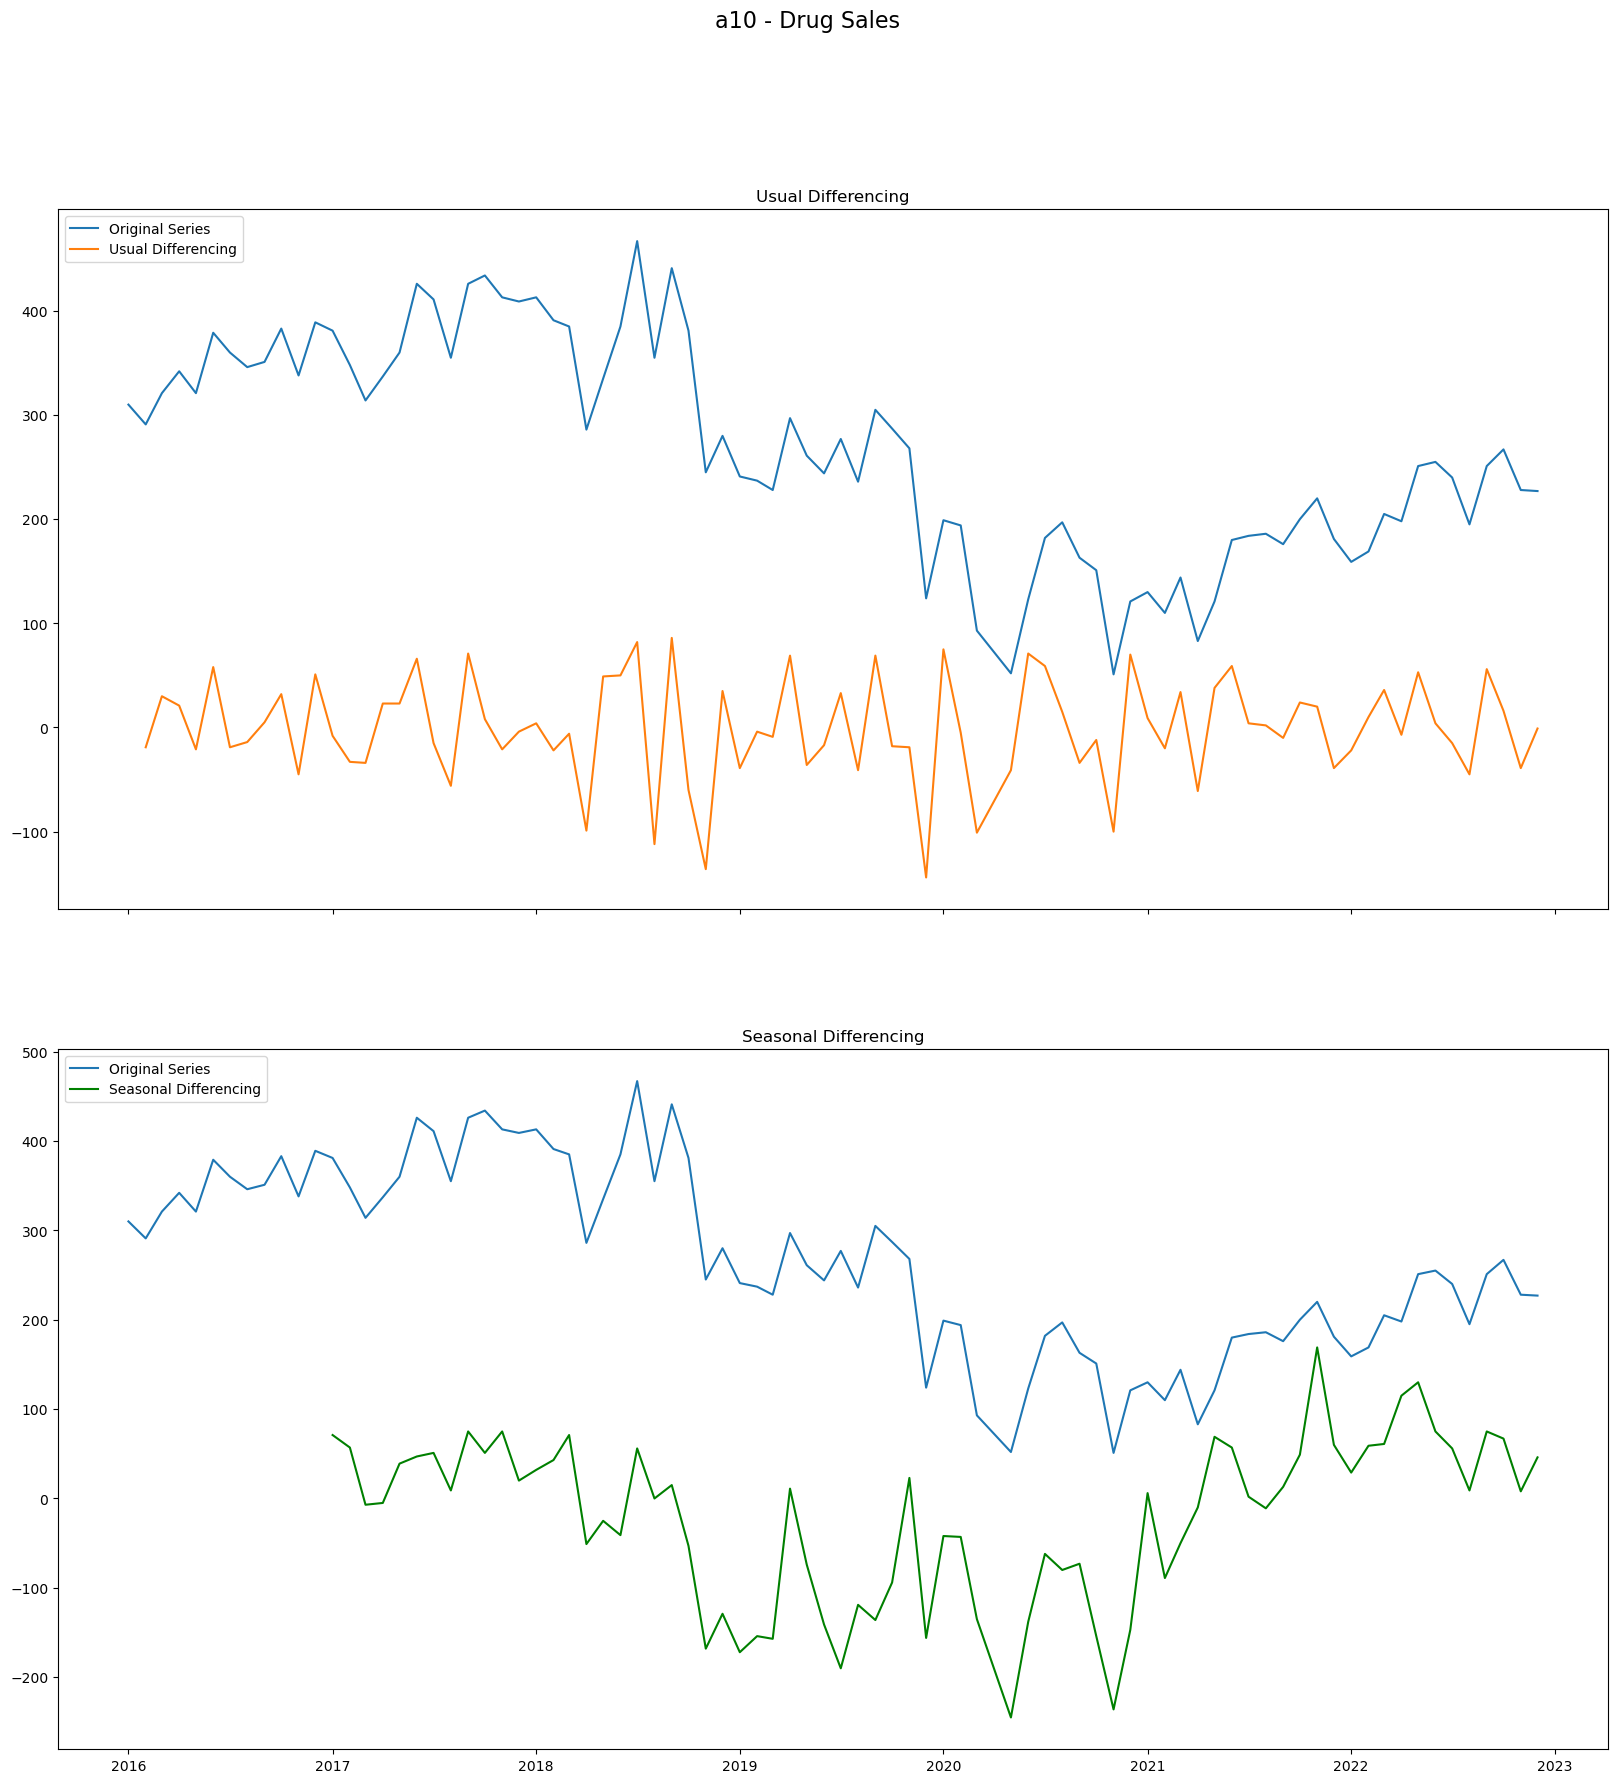

In [47]:

# Plot
fig, axes = plt.subplots(2, 1, figsize=(20,20), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df_date_month[:], label='Original Series')
axes[0].plot(df_date_month[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(df_date_month[:], label='Original Series')
axes[1].plot(df_date_month[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [48]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df_date_month, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=792.429, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=770.684, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=790.933, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=764.295, Time=0.31 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=763.889, Time=0.42 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=763.920, Time=0.47 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.33 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=767.415, Time=0.26 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.50 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   83
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -377.944
Date:                              Thu, 05 Jan 2023   AIC                            763.889
Time:                                      15:02:53   BIC                            772.883
Sample:                                           0   HQIC                           767.461
                                               - 83                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2774      0.118     -2.348      0.019      -0.509      -0.046
ar.S.L12      -0.1027      0.234     -0.439      0.660      -0.561       0.355
ma.S.L12      -0.7854      0.405     -1.941      0.052      -1.578       0.007
sigma2      2379.4668    622.029      3.825      0.000    1160.313    3598.621
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 4.57
Prob(Q):                              0.57   Prob(JB):                         0.10
Heteroskedasticity (H):               0.76   Skew:                            -0.59
Prob(H) (two-sided):                  0.52   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
data.index[-1]

Timestamp('2008-06-01 00:00:00')

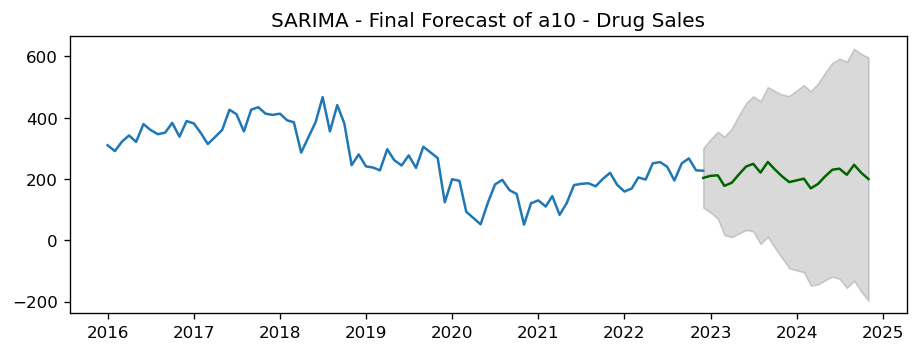

In [50]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df_date_month.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_date_month)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

In [91]:
df_date_month_train = df_date_month[:-9]
df_date_month_test = df_date_month[-9::]

In [105]:
df_date_month_test

,item_lost
year_month,
2022-04-01,198
2022-05-01,251
2022-06-01,255
2022-07-01,240
2022-08-01,195
2022-09-01,251
2022-10-01,267
2022-11-01,228
2022-12-01,227


In [80]:
df_date_month_train

,item_lost
year_month,
2016-01-01,310
2016-02-01,291
2016-03-01,321
2016-04-01,342
2016-05-01,321
...,...
2021-08-01,186
2021-09-01,176
2021-10-01,200


In [92]:
# Seasonal - fit stepwise auto-ARIMA
smodeltrain = pm.auto_arima(df_date_month_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodeltrain.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=695.745, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=672.421, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=694.660, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=670.011, Time=0.30 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=667.575, Time=0.31 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=1.27 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=667.650, Time=0.64 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.51 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=671.601, Time=0.23 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.60 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   74
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -329.787
Date:                              Fri, 06 Jan 2023   AIC                            667.575
Time:                                      16:17:38   BIC                            676.018
Sample:                                           0   HQIC                           670.884
                                               - 74                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3109      0.136     -2.286      0.022      -0.577      -0.044
ar.S.L12      -0.1541      0.267     -0.577      0.564      -0.678       0.370
ma.S.L12      -0.8320      0.640     -1.300      0.194      -2.087       0.423
sigma2      2241.3275   1023.433      2.190      0.029     235.436    4247.219
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 6.10
Prob(Q):                              0.51   Prob(JB):                         0.05
Heteroskedasticity (H):               1.45   Skew:                            -0.70
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

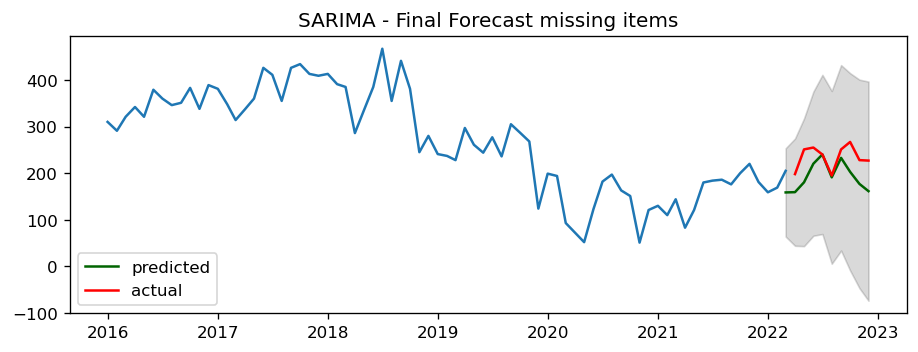

In [106]:
# Forecast
n_periods = 10
fitted, confint = smodeltrain.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df_date_month_train.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_date_month_train)
plt.plot(fitted_series, color='darkgreen', label='predicted')
plt.plot(df_date_month_test,color='red', label='actual')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.legend(loc=3)
plt.title("SARIMA - Final Forecast missing items")
plt.show()

In [107]:
df_date_month_test

,item_lost
year_month,
2022-04-01,198
2022-05-01,251
2022-06-01,255
2022-07-01,240
2022-08-01,195
2022-09-01,251
2022-10-01,267
2022-11-01,228
2022-12-01,227


In [108]:
fitted_series

2022-03-01    158.690294
2022-04-01    159.269270
2022-05-01    180.437366
2022-06-01    220.336167
2022-07-01    240.174517
2022-08-01    191.034537
2022-09-01    232.851314
2022-10-01    202.836792
2022-11-01    176.938997
2022-12-01    161.411811
Freq: MS, dtype: float64

In [109]:
fitted_series_mae = fitted_series[1:]

In [110]:
fitted_series_mae

2022-04-01    159.269270
2022-05-01    180.437366
2022-06-01    220.336167
2022-07-01    240.174517
2022-08-01    191.034537
2022-09-01    232.851314
2022-10-01    202.836792
2022-11-01    176.938997
2022-12-01    161.411811
Freq: MS, dtype: float64

In [111]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print ("MAE for classical approach:",mean_absolute_error(df_date_month_test['item_lost'], fitted_series_mae))

MAE for classical approach: 38.5620292945229


# Try with train test split

In [57]:
df_date_month_split = df_date_month.reset_index()

In [58]:
df_date_month_split

,year_month,item_lost
0,2016-01-01,310
1,2016-02-01,291
2,2016-03-01,321
3,2016-04-01,342
4,2016-05-01,321
...,...,...
78,2022-08-01,195
79,2022-09-01,251
80,2022-10-01,267
81,2022-11-01,228


In [59]:
df_date_month_split

,year_month,item_lost
0,2016-01-01,310
1,2016-02-01,291
2,2016-03-01,321
3,2016-04-01,342
4,2016-05-01,321
...,...,...
78,2022-08-01,195
79,2022-09-01,251
80,2022-10-01,267
81,2022-11-01,228


In [60]:
from sklearn.model_selection import TimeSeriesSplit

X = df_date_month_split

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    # y_train, y_test = y[train_index], y[test_index]

# Next, let's import and initialize the XGBoost model
# import xgboost as xgb

# model = xgb.XGBRegressor()

# # Now, let's fit the model to the training data
# model.fit(X_train, y_train)

# # And finally, let's make predictions on the test set and evaluate the model
# y_pred = model.predict(X_test)

# from sklearn.metrics import mean_squared_error

# print(mean_squared_error(y_test, y_pred))

In [61]:
X_test

,year_month,item_lost
70,2021-12-01,181
71,2022-01-01,159
72,2022-02-01,169
73,2022-03-01,205
74,2022-04-01,198
75,2022-05-01,251
76,2022-06-01,255
77,2022-07-01,240
78,2022-08-01,195
79,2022-09-01,251


# Try with all day


In [62]:
df_date_day =df_input_full

In [63]:
df_date_day['date_only'] = pd.to_datetime(df_date_day['date_only']) 

In [64]:
df_date_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447 entries, 0 to 2446
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_only  2447 non-null   datetime64[ns]
 1   item_lost  2447 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 38.4 KB


In [65]:
df_date_day.set_index('date_only', inplace=True)

In [66]:
df_date_day.sort_index(inplace=True)

In [67]:
df_date_day

,item_lost
date_only,
2016-01-01,1
2016-01-02,8
2016-01-03,8
2016-01-04,12
2016-01-05,4
...,...
2022-12-27,2
2022-12-28,4
2022-12-29,13


In [68]:
df_date_day_test = df_date_day[-99::]
df_date_day_train = df_date_day[:-99]

In [69]:
# Seasonal - fit stepwise auto-ARIMA
smodel_daytrain = pm.auto_arima(df_date_day_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=30,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel_daytrain.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[30] intercept   : AIC=inf, Time=46.86 sec
 ARIMA(0,0,0)(0,1,0)[30] intercept   : AIC=15196.881, Time=0.43 sec
 ARIMA(1,0,0)(1,1,0)[30] intercept   : AIC=14589.204, Time=9.56 sec
 ARIMA(0,0,1)(0,1,1)[30] intercept   : AIC=inf, Time=9.65 sec
 ARIMA(0,0,0)(0,1,0)[30]             : AIC=15194.908, Time=0.33 sec
 ARIMA(1,0,0)(0,1,0)[30] intercept   : AIC=15195.440, Time=1.39 sec
 ARIMA(1,0,0)(2,1,0)[30] intercept   : AIC=14350.014, Time=29.25 sec
 ARIMA(1,0,0)(2,1,1)[30] intercept   : AIC=inf, Time=42.61 sec
 ARIMA(1,0,0)(1,1,1)[30] intercept   : AIC=inf, Time=15.41 sec
 ARIMA(0,0,0)(2,1,0)[30] intercept   : AIC=14350.212, Time=23.08 sec
 ARIMA(2,0,0)(2,1,0)[30] intercept   : AIC=14351.563, Time=42.65 sec
 ARIMA(1,0,1)(2,1,0)[30] intercept   : AIC=14307.020, Time=133.09 sec
 ARIMA(1,0,1)(1,1,0)[30] intercept   : AIC=14560.753, Time=31.96 sec
 ARIMA(1,0,1)(2,1,1)[30] intercept   : AIC=inf, Time=135.23 sec
 ARIMA(1,0,1)(1,1,1)[30]

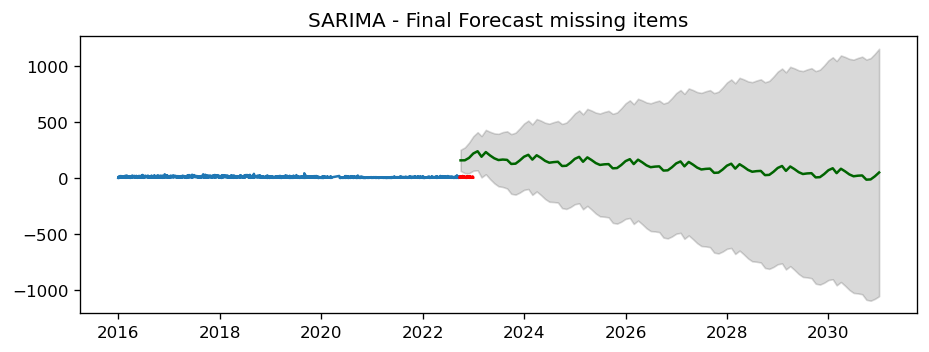

In [90]:
# Forecast
n_periods = 100
fitted, confint = smodeltrain.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df_date_day_train.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_date_day_train)
plt.plot(fitted_series, color='darkgreen')
plt.plot(df_date_day_test,color='red')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast missing items")
plt.show()

# SARIMAX Model with exogenous variable

In [107]:
# Import Data
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index.

In [141]:
data

,value,month
date,,
1991-07-01,3.526591,7
1991-08-01,3.180891,8
1991-09-01,3.252221,9
1991-10-01,3.611003,10
1991-11-01,3.565869,11
...,...,...
2008-02-01,21.654285,2
2008-03-01,18.264945,3
2008-04-01,23.107677,4


In [112]:
df.head()

,value,month,seasonal_index
date,,,
1991-07-01,3.526591,7,0.970490
1991-08-01,3.180891,8,1.050900
1991-09-01,3.252221,9,0.998881
1991-10-01,3.611003,10,1.059657
1991-11-01,3.565869,11,1.146141


In [115]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=536.818, Time=1.21 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=626.061, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=598.068, Time=0.46 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=613.475, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=759.274, Time=0.21 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=561.407, Time=0.41 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=538.817, Time=2.46 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=545.106, Time=0.80 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=539.955, Time=3.34 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=596.467, Time=0.29 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=531.829, Time=0.77 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=557.198, Time=0.34 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -254.002
Date:                            Wed, 04 Jan 2023   AIC                            526.004
Time:                                    16:35:49   BIC                            555.321
Sample:                                07-01-1991   HQIC                           537.878
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0052      0.009      0.563      0.574      -0.013       0.023
seasonal_index  8.842e-07   4928.216   1.79e-10      1.000   -9659.126    9659.126
ar.L1              0.9760      0.019     52.522      0.000       0.940       1.012
ma.L1             -0.8964      0.057    -15.792      0.000      -1.008      -0.785
ma.L2              0.2059      0.058      3.538      0.000       0.092       0.320
ar.S.L12           0.8429      0.170      4.972      0.000       0.511       1.175
ma.S.L12          -1.5672      0.189     -8.275      0.000      -1.938      -1.196
ma.S.L24           0.7419      0.114      6.518      0.000       0.519       0.965
sigma2             0.7533      0.064     11.833      0.000       0.629       0.878
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):               141.97
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):              14.54   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [116]:
result_mul

In [122]:
seasonal_index

,seasonal,month
date,,
2007-07-01,0.970490,7
2007-08-01,1.050900,8
2007-09-01,0.998881,9
2007-10-01,1.059657,10
2007-11-01,1.146141,11
2007-12-01,1.150750,12
2008-01-01,1.316913,1
2008-02-01,0.803279,2
2008-03-01,0.850667,3


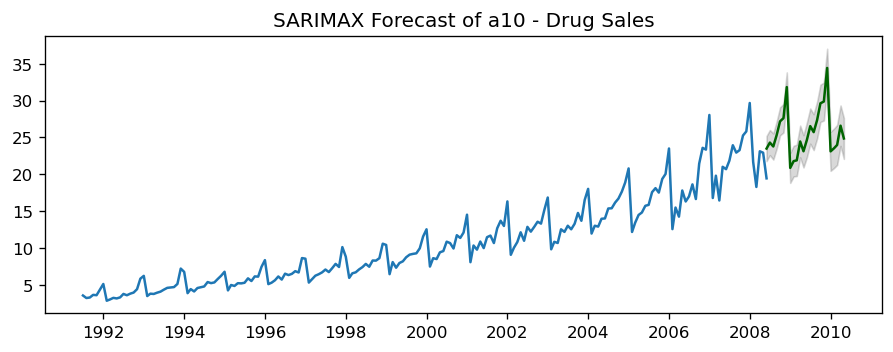

In [123]:
# Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.seasonal, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()

In [146]:
data

,value,month
date,,
1991-07-01,3.526591,7
1991-08-01,3.180891,8
1991-09-01,3.252221,9
1991-10-01,3.611003,10
1991-11-01,3.565869,11
...,...,...
2008-02-01,21.654285,2
2008-03-01,18.264945,3
2008-04-01,23.107677,4


In [147]:
df_date_month

,item_lost
year_month,
2016-01-01,310
2016-10-01,383
2016-11-01,338
2016-12-01,389
2016-02-01,291
...,...
2022-05-01,251
2022-06-01,255
2022-07-01,240


In [148]:
df_date_month['item_lost'][-36:]

year_month
2019-09-01    305
2020-01-01    199
2020-10-01    151
2020-11-01     51
2020-12-01    121
2020-02-01    194
2020-03-01     93
2020-05-01     52
2020-06-01    123
2020-07-01    182
2020-08-01    197
2020-09-01    163
2021-01-01    130
2021-10-01    200
2021-11-01    220
2021-12-01    181
2021-02-01    110
2021-03-01    144
2021-04-01     83
2021-05-01    121
2021-06-01    180
2021-07-01    184
2021-08-01    186
2021-09-01    176
2022-01-01    159
2022-10-01    267
2022-11-01    228
2022-12-01    227
2022-02-01    169
2022-03-01    205
2022-04-01    198
2022-05-01    251
2022-06-01    255
2022-07-01    240
2022-08-01    195
2022-09-01    251
Name: item_lost, dtype: int64

In [151]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(df_date_month['item_lost'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')



ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:
seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index.